# Power Curve

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib as mpl
import seaborn as sns
import numpy as np
import pandas as pd
import sys
sys.path.insert(0, "../scripts")

from power_analysis import compute_prob_table, power_from_prob_table, power_from_multiple_rows
from learning_theory import n1_requirement

In [2]:
df = pd.read_csv("../reports/0830_gaussian_noised_past_present.csv")
print(df.shape)
df.test_predictions = df.test_predictions.combine(
    df.best_test_predictions,  # In some trials, the values are written to the "best_test_predictions" column.
    lambda x,y: x if x.__class__ == str else y
)
print(df.representation_gaussian_noise.drop_duplicates().tolist())
all_val_sizes = sorted(df.val_size_per_class.drop_duplicates().tolist())
print(all_val_sizes)
noise_choices = [0.01, 0.03, 0.10, 0.30, 1.00, 3.00]
df.columns

(1245, 27)
[0.1, 1.0, 3.0, 0.01, 0.3, 0.03, 0.0]
[32, 128, 512, 2048, 8192]


Index(['Name', 'Created', 'Runtime', 'State', 'Updated', 'Hostname',
       'max_epochs', 'task', 'probe_metric', 'hid_sizes', 'seed',
       'train_size_per_class', 'val_size_per_class', 'use_cuda', 'model',
       'slurm_id', 'min_epochs', 'representation_gaussian_noise',
       'best_hyperparameters.batch_size', 'best_hyperparameters.lr',
       'test_loss', 'best_val_acc', 'best_val_loss', 'test_acc',
       'best_test_predictions', 'test_labels', 'test_predictions'],
      dtype='object')

In [3]:
bg_df = pd.read_csv("../reports/0922_bigram_shift.csv")
print(bg_df.val_size_per_class.drop_duplicates())
bg_df.shape

0     2048
4       32
6     8192
7      128
17     512
Name: val_size_per_class, dtype: int64


(175, 27)

In [4]:
hid20_df = pd.read_csv("../reports/0927_past_present_bigram_shift_hidsize20.csv")
hid20_df.shape

(50, 27)

In [5]:
sentlen_df = pd.read_csv("../reports/1012_sentence_length.csv")
sentlen_df.shape

(160, 26)

In [6]:
coordinv_df = pd.read_csv("../reports/1012_coordination_inversion.csv")
coordinv_df.shape

(200, 26)

In [7]:
df_all = pd.concat([df, bg_df, hid20_df, sentlen_df, coordinv_df], axis=0)
df_all.shape

(1830, 27)

## Power vs noise

/Users/zhuzi/miniforge3/envs/pytorch12/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/zhuzi/miniforge3/envs/pytorch12/lib/python3.9/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/zhuzi/miniforge3/envs/pytorch12/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/zhuzi/miniforge3/envs/pytorch12/lib/python3.9/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/zhuzi/miniforge3/envs/pytorch12/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/zhuzi/miniforge3/envs/pytorch12/lib/python3.9/si

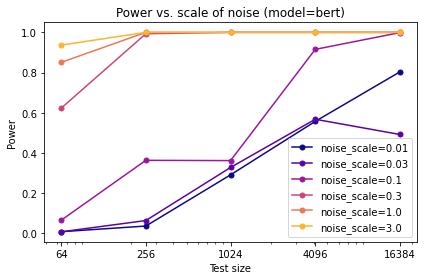

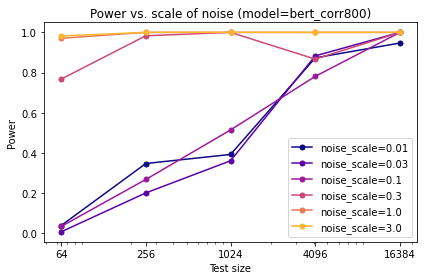

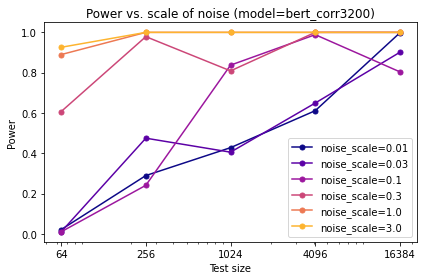

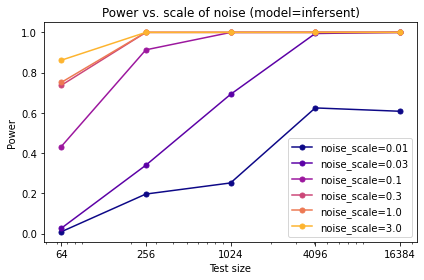

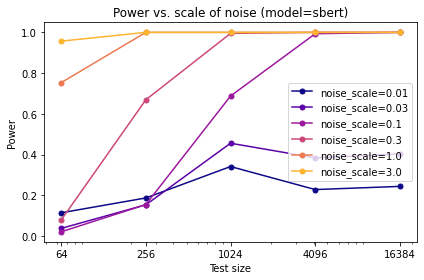

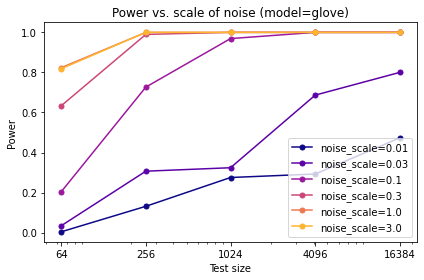

In [6]:
def compute_powers_within_model(df, val_size, noise, model="bert", metric="others"):
    df_baseline = df[(df.model==model) & (df.probe_metric==metric) & \
                      (df.val_size_per_class==val_size) & \
                      (df.representation_gaussian_noise==0) & \
                      (df.seed < 64)]

    df_noised = df[(df.model==model) & (df.probe_metric==metric) & \
                    (df.val_size_per_class==val_size) & \
                    (df.representation_gaussian_noise==noise)]
    
    #print(f"model={model}, val_size={val_size}, metric={metric}, noise={noise}")

    power = power_from_multiple_rows(df_baseline, df_noised, 
            pred_col_name="test_predictions", label_col_name="test_labels")

    return power


def make_power_plot(df, model="bert"):
    N_CLASS = 2
    fig, ax = plt.subplots(1,1)
    cmap = plt.get_cmap("plasma")
    norm = mpl.colors.Normalize(vmin=0, vmax=len(noise_choices))
    for i, noise in enumerate(noise_choices):
        powers = []
        for vsize in all_val_sizes:
            power = compute_powers_within_model(df, vsize, noise, model)
            powers.append(power)
        ax.plot(np.array(all_val_sizes)*N_CLASS, powers, label=f"noise_scale={noise}", 
                color=cmap(norm(i), bytes=False),
                marker="o", markersize=5)
    ax.set_xscale("log")
    ax.set_xticks([64, 256, 1024, 4096, 16384])
    ax.set_xticklabels(["64", "256", "1024", "4096", "16384"])
    ax.set_xlabel("Test size")
    ax.set_ylabel("Power")
    plt.title("Power vs. scale of noise (model={})".format(model))
    plt.legend()
    plt.tight_layout()
    plt.savefig(f"compare_models_plot/power_plot_{model}.svg")
    
make_power_plot(df, "bert")
make_power_plot(df, "bert_corr800")
make_power_plot(df, "bert_corr3200")
make_power_plot(df, "infersent")
make_power_plot(df, "sbert")
make_power_plot(df, "glove")

## Compare between encoders

coordination_inversion,32,bert,sbert,5,5,0.0063,9818035,9818035,False
coordination_inversion,128,bert,sbert,5,5,0.0297,435148,435148,False
coordination_inversion,512,bert,sbert,5,5,0.0230,722038,722038,False
coordination_inversion,2048,bert,sbert,5,5,0.0032,36928076,36928076,False
coordination_inversion,8192,bert,sbert,5,5,-0.0063,9818035,9818035,True


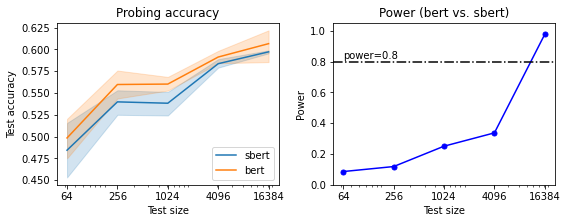

coordination_inversion,32,bert,infersent,5,5,-0.0250,613627,635040,False
coordination_inversion,128,bert,infersent,5,5,-0.0187,1090892,1128961,False
coordination_inversion,512,bert,infersent,5,5,-0.0414,223693,231499,False
coordination_inversion,2048,bert,infersent,5,5,-0.0511,146740,151861,True
coordination_inversion,8192,bert,infersent,5,5,-0.0630,96776,100153,True


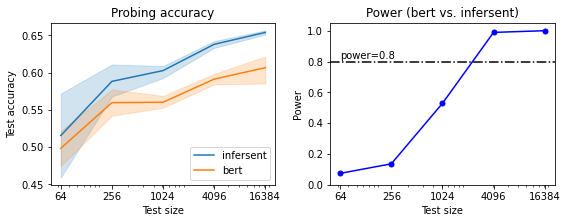

coordination_inversion,32,bert,glove,5,5,0.0094,4363571,4278194,False
coordination_inversion,128,bert,glove,5,5,0.0750,68180,66846,False
coordination_inversion,512,bert,glove,5,5,0.0479,167491,164214,False
coordination_inversion,2048,bert,glove,5,5,0.0681,82660,81042,True
coordination_inversion,8192,bert,glove,5,5,0.0578,114795,112549,True


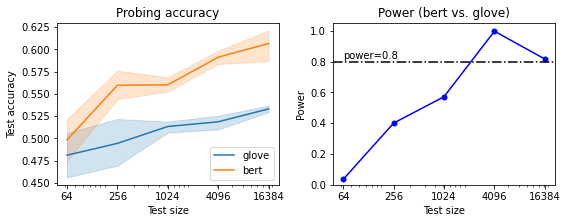

coordination_inversion,32,sbert,infersent,5,5,-0.0312,392721,406425,False
coordination_inversion,128,sbert,infersent,5,5,-0.0484,163463,169167,False
coordination_inversion,512,sbert,infersent,5,5,-0.0645,92320,95541,False
coordination_inversion,2048,sbert,infersent,5,5,-0.0543,129853,134385,True
coordination_inversion,8192,sbert,infersent,5,5,-0.0567,119286,123449,True


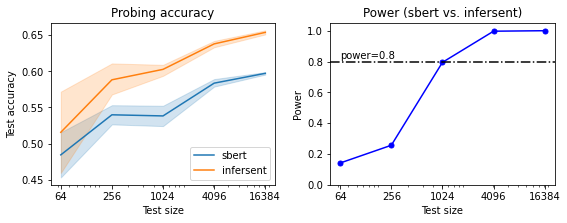

coordination_inversion,32,sbert,glove,5,5,0.0031,39272143,38503750,False
coordination_inversion,128,sbert,glove,5,5,0.0453,186787,183133,False
coordination_inversion,512,sbert,glove,5,5,0.0248,623328,611132,False
coordination_inversion,2048,sbert,glove,5,5,0.0649,91074,89292,True
coordination_inversion,8192,sbert,glove,5,5,0.0641,93485,91655,True


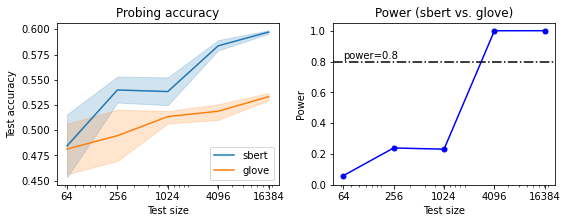

coordination_inversion,32,infersent,glove,5,5,0.0344,335889,318212,False
coordination_inversion,128,infersent,glove,5,5,0.0938,45158,42781,False
coordination_inversion,512,infersent,glove,5,5,0.0893,49818,47196,True
coordination_inversion,2048,infersent,glove,5,5,0.1192,27915,26446,True
coordination_inversion,8192,infersent,glove,5,5,0.1208,27220,25787,True


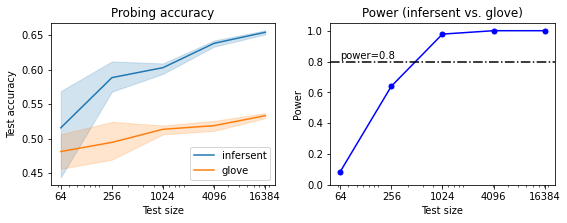

coordination_inversion,32,bert,bert_corr200,5,5,0.0000,nan,nan,False
coordination_inversion,128,bert,bert_corr200,5,5,0.0539,131979,131979,False
coordination_inversion,512,bert,bert_corr200,5,5,0.0277,498594,498594,False
coordination_inversion,2048,bert,bert_corr200,5,5,0.0762,66099,66099,True
coordination_inversion,8192,bert,bert_corr200,5,5,0.0556,123884,123884,True


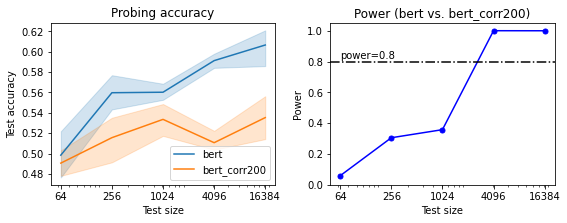

coordination_inversion,32,bert,bert_corr800,5,5,-0.0344,324563,324563,False
coordination_inversion,128,bert,bert_corr800,5,5,0.0836,54882,54882,False
coordination_inversion,512,bert,bert_corr800,5,5,0.0506,149873,149873,False
coordination_inversion,2048,bert,bert_corr800,5,5,0.0696,79105,79105,True
coordination_inversion,8192,bert,bert_corr800,5,5,0.0845,53715,53715,True


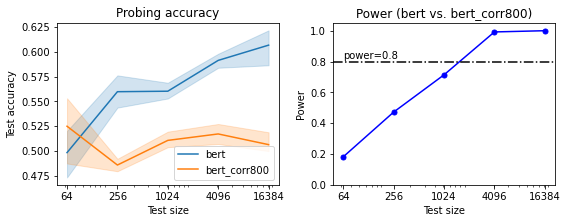

coordination_inversion,32,bert,bert_corr3200,5,5,-0.0094,4363571,4363571,False
coordination_inversion,128,bert,bert_corr3200,5,5,0.0664,86969,86969,False
coordination_inversion,512,bert,bert_corr3200,5,5,0.0563,121210,121210,False
coordination_inversion,2048,bert,bert_corr3200,5,5,0.0726,72846,72846,True
coordination_inversion,8192,bert,bert_corr3200,5,5,0.0744,69326,69326,True


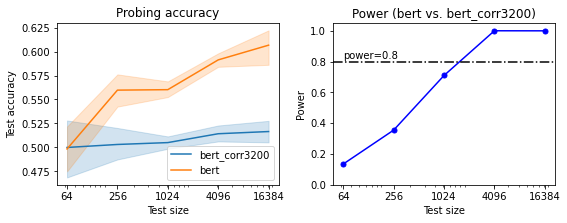

sentence_length,32,bert,sbert,5,5,0.0729,72132,72132,False
sentence_length,128,bert,sbert,5,5,0.0492,158315,158315,False
sentence_length,512,bert,sbert,5,5,-0.0379,267129,267129,False
sentence_length,2048,bert,sbert,5,5,-0.0381,263944,263944,True


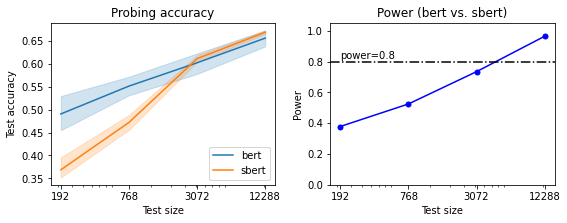

sentence_length,32,bert,infersent,5,5,-0.0646,91948,95156,False
sentence_length,128,bert,infersent,5,5,-0.1276,23553,24375,True
sentence_length,512,bert,infersent,5,5,-0.1783,12060,12481,True
sentence_length,2048,bert,infersent,5,5,-0.1964,9939,10285,True


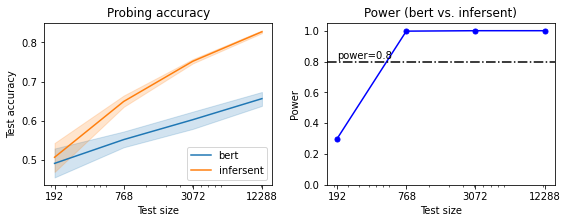

sentence_length,32,bert,glove,5,5,0.0333,345165,338411,False
sentence_length,128,bert,glove,5,5,0.0310,399349,391535,False
sentence_length,512,bert,glove,5,5,0.0066,8696945,8526782,False
sentence_length,2048,bert,glove,5,5,0.0334,344492,337751,True


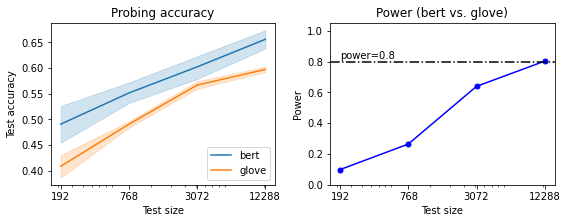

sentence_length,32,sbert,infersent,5,5,-0.1375,20285,20993,False
sentence_length,128,sbert,infersent,5,5,-0.1768,12266,12694,True
sentence_length,512,sbert,infersent,5,5,-0.1404,19447,20126,True
sentence_length,2048,sbert,infersent,5,5,-0.1583,15301,15835,True


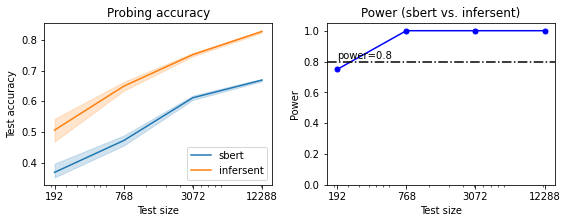

sentence_length,32,sbert,glove,5,5,-0.0396,244770,239981,False
sentence_length,128,sbert,glove,5,5,-0.0182,1154120,1131538,False
sentence_length,512,sbert,glove,5,5,0.0445,193399,189615,True
sentence_length,2048,sbert,glove,5,5,0.0715,75052,73583,True


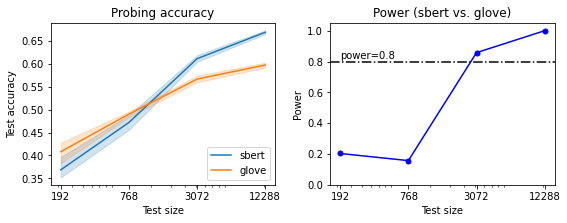

sentence_length,32,infersent,glove,5,5,0.0979,41396,39218,False
sentence_length,128,infersent,glove,5,5,0.1586,15780,14949,True
sentence_length,512,infersent,glove,5,5,0.1850,11601,10991,True
sentence_length,2048,infersent,glove,5,5,0.2298,7515,7120,True


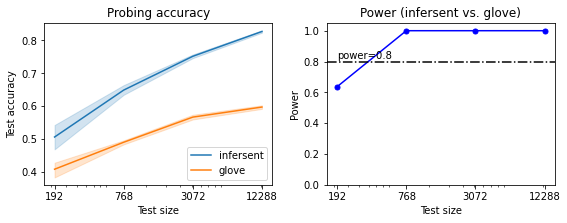

sentence_length,32,bert,bert_corr200,5,5,-0.0187,1090892,1090892,False
sentence_length,128,bert,bert_corr200,5,5,-0.0039,25134172,25134172,False
sentence_length,512,bert,bert_corr200,5,5,-0.0112,3058512,3058512,False
sentence_length,2048,bert,bert_corr200,5,5,0.0327,359411,359411,True


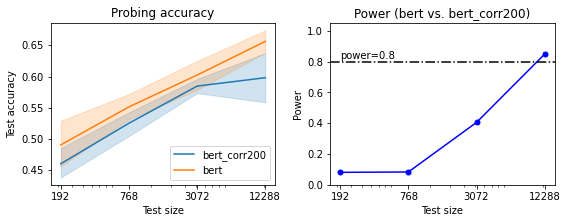

sentence_length,32,bert,bert_corr800,5,5,-0.0437,200368,200368,False
sentence_length,128,bert,bert_corr800,5,5,0.0016,157088575,157088575,False
sentence_length,512,bert,bert_corr800,5,5,-0.0352,309152,309152,False
sentence_length,2048,bert,bert_corr800,5,5,-0.0369,281201,281201,True


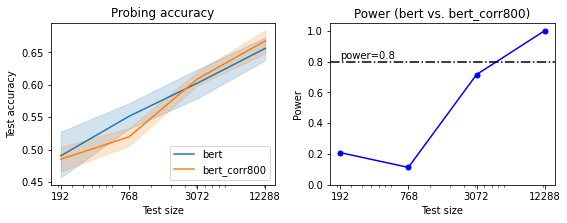

sentence_length,32,bert,bert_corr3200,5,5,-0.0521,141379,141379,False
sentence_length,128,bert,bert_corr3200,5,5,-0.0003,5655188708,5655188708,False
sentence_length,512,bert,bert_corr3200,5,5,-0.0118,2761912,2761912,True
sentence_length,2048,bert,bert_corr3200,5,5,0.0173,1283624,1283624,True


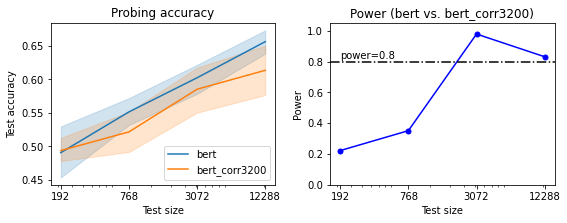

bigram_shift,32,bert,sbert,5,5,0.1094,32058,32058,False
bigram_shift,128,bert,sbert,5,5,0.0273,512942,512942,False
bigram_shift,512,bert,sbert,5,5,-0.0123,2533048,2533048,False
bigram_shift,2048,bert,sbert,5,5,-0.0234,698171,698171,False
bigram_shift,8192,bert,sbert,5,5,-0.0208,890567,890567,False


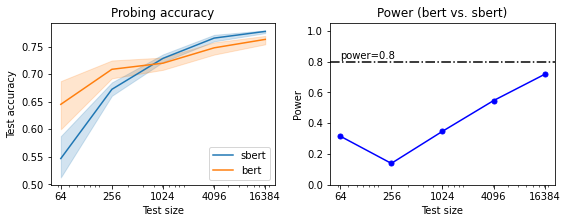

bigram_shift,32,bert,infersent,5,5,0.1469,17778,18398,False
bigram_shift,128,bert,infersent,5,5,0.1922,10383,10745,True
bigram_shift,512,bert,infersent,5,5,0.1973,9855,10199,True
bigram_shift,2048,bert,infersent,5,5,0.2050,9123,9441,True
bigram_shift,8192,bert,infersent,5,5,0.2018,9418,9746,True


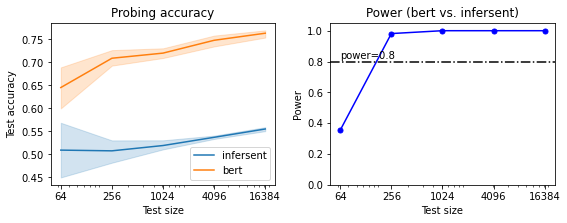

bigram_shift,32,bert,glove,5,5,0.1281,23362,22905,False
bigram_shift,128,bert,glove,5,5,0.1859,11093,10875,True
bigram_shift,512,bert,glove,5,5,0.2186,8029,7871,True
bigram_shift,2048,bert,glove,5,5,0.2443,6424,6298,True
bigram_shift,8192,bert,glove,5,5,0.2581,5758,5645,True


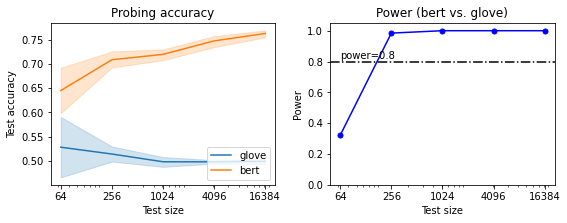

bigram_shift,32,sbert,infersent,5,5,0.0375,272723,282240,False
bigram_shift,128,sbert,infersent,5,5,0.1648,14113,14606,True
bigram_shift,512,sbert,infersent,5,5,0.2096,8732,9036,True
bigram_shift,2048,sbert,infersent,5,5,0.2285,7347,7603,True
bigram_shift,8192,sbert,infersent,5,5,0.2225,7743,8013,True


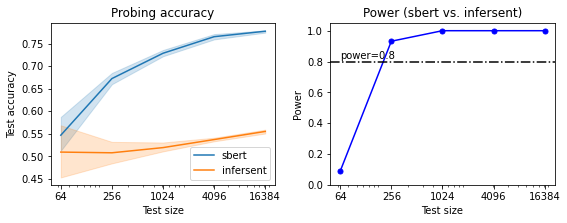

bigram_shift,32,sbert,glove,5,5,0.0187,1090892,1069548,False
bigram_shift,128,sbert,glove,5,5,0.1586,15247,14949,True
bigram_shift,512,sbert,glove,5,5,0.2309,7195,7055,True
bigram_shift,2048,sbert,glove,5,5,0.2678,5348,5244,True
bigram_shift,8192,sbert,glove,5,5,0.2788,4932,4836,True


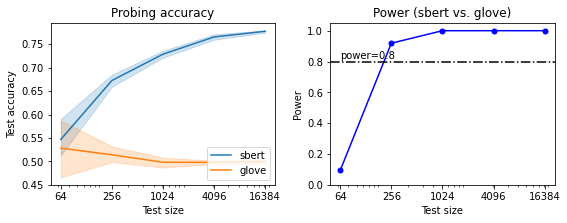

bigram_shift,32,infersent,glove,5,5,-0.0187,1128961,1069548,False
bigram_shift,128,infersent,glove,5,5,-0.0063,10160649,9625937,False
bigram_shift,512,infersent,glove,5,5,0.0213,875726,829640,False
bigram_shift,2048,infersent,glove,5,5,0.0393,256891,243372,True
bigram_shift,8192,infersent,glove,5,5,0.0563,125276,118684,True


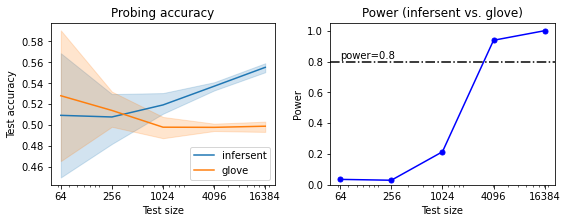

bigram_shift,32,bert,bert_corr200,5,5,0.1313,22263,22263,False
bigram_shift,128,bert,bert_corr200,5,5,0.1281,23362,23362,True
bigram_shift,512,bert,bert_corr200,5,5,0.0879,49647,49647,True
bigram_shift,2048,bert,bert_corr200,5,5,0.1331,21662,21662,True
bigram_shift,8192,bert,bert_corr200,5,5,0.1488,17331,17331,True


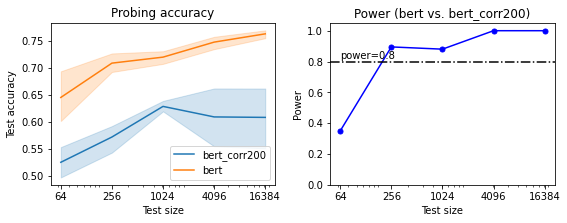

bigram_shift,32,bert,bert_corr800,5,5,0.1656,13980,13980,False
bigram_shift,128,bert,bert_corr800,5,5,0.1508,16869,16869,True
bigram_shift,512,bert,bert_corr800,5,5,0.1686,13499,13499,True
bigram_shift,2048,bert,bert_corr800,5,5,0.1569,15572,15572,True
bigram_shift,8192,bert,bert_corr800,5,5,0.1787,12013,12013,True


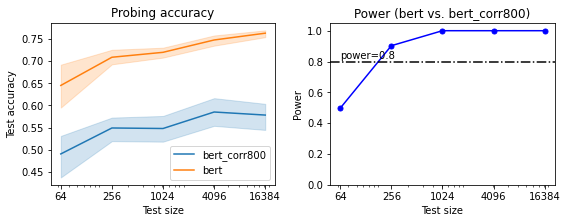

bigram_shift,32,bert,bert_corr3200,5,5,0.1719,12982,12982,False
bigram_shift,128,bert,bert_corr3200,5,5,0.2125,8493,8493,True
bigram_shift,512,bert,bert_corr3200,5,5,0.2010,9494,9494,True
bigram_shift,2048,bert,bert_corr3200,5,5,0.2368,6838,6838,True
bigram_shift,8192,bert,bert_corr3200,5,5,0.2033,9277,9277,True


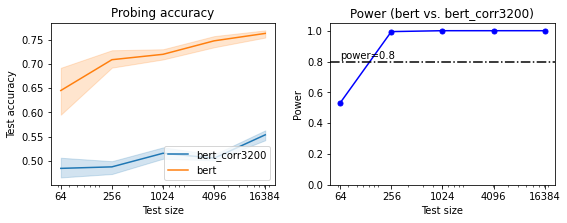

past_present,32,bert,sbert,5,5,0.0469,174542,174542,False
past_present,128,bert,sbert,5,5,0.0336,339834,339834,False
past_present,512,bert,sbert,5,5,0.0004,2513417203,2513417203,False
past_present,2048,bert,sbert,5,5,-0.0483,164456,164456,False
past_present,8192,bert,sbert,5,5,-0.0080,5962574,5962574,False


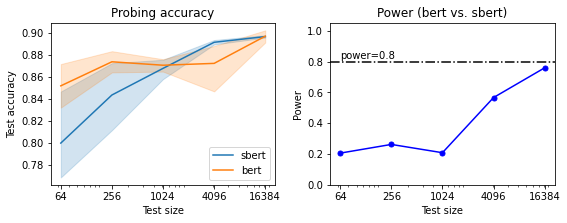

past_present,32,bert,infersent,5,5,0.0406,232379,240488,False
past_present,128,bert,infersent,5,5,0.0555,124648,128998,False
past_present,512,bert,infersent,5,5,0.0324,364844,377576,False
past_present,2048,bert,infersent,5,5,-0.0296,436583,451818,False
past_present,8192,bert,infersent,5,5,0.0046,18498941,19144487,False


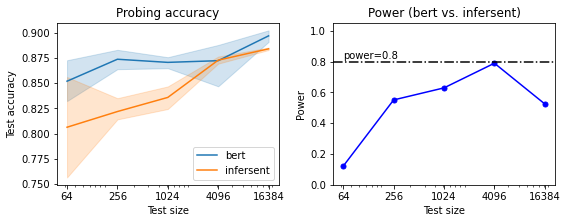

past_present,32,bert,glove,5,5,0.0344,324563,318212,False
past_present,128,bert,glove,5,5,0.0492,158315,155217,False
past_present,512,bert,glove,5,5,0.0355,303516,297577,False
past_present,2048,bert,glove,5,5,-0.0091,4600037,4510033,True
past_present,8192,bert,glove,5,5,0.0320,373513,366205,True


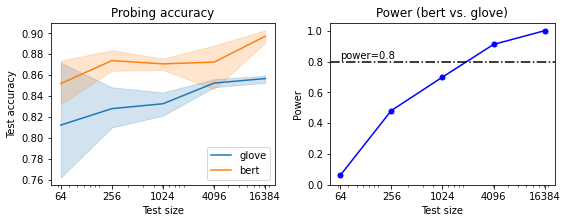

past_present,32,sbert,infersent,5,5,-0.0063,9818035,10160649,False
past_present,128,sbert,infersent,5,5,0.0219,801472,829440,False
past_present,512,sbert,infersent,5,5,0.0320,373797,386842,False
past_present,2048,sbert,infersent,5,5,0.0187,1102345,1140813,True
past_present,8192,sbert,infersent,5,5,0.0126,2425996,2510654,True


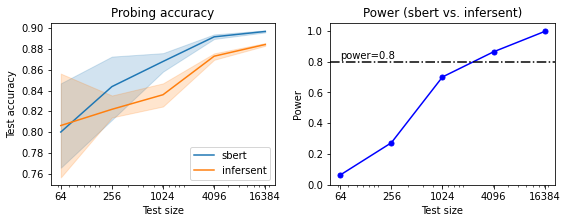

past_present,32,sbert,glove,5,5,-0.0125,2454508,2406484,False
past_present,128,sbert,glove,5,5,0.0156,1570885,1540150,False
past_present,512,sbert,glove,5,5,0.0352,310298,304227,False
past_present,2048,sbert,glove,5,5,0.0392,250089,245196,True
past_present,8192,sbert,glove,5,5,0.0401,238939,234264,True


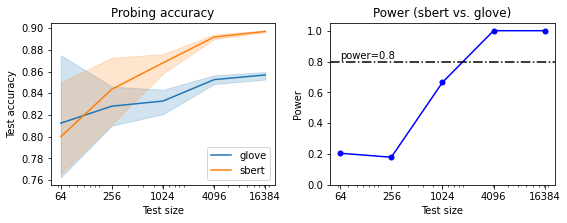

past_present,32,infersent,glove,5,5,-0.0063,10160649,9625937,False
past_present,128,infersent,glove,5,5,-0.0063,10160649,9625937,False
past_present,512,infersent,glove,5,5,0.0031,40642599,38503750,False
past_present,2048,infersent,glove,5,5,0.0205,943719,894055,True
past_present,8192,infersent,glove,5,5,0.0275,525199,497560,True


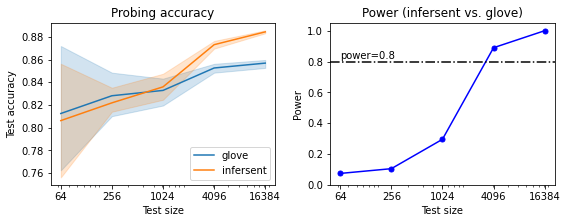

past_present,32,bert,bert_corr200,5,5,-0.0063,9818035,9818035,False
past_present,128,bert,bert_corr200,5,5,0.0125,2454508,2454508,False
past_present,512,bert,bert_corr200,5,5,-0.0100,3865309,3865309,False
past_present,2048,bert,bert_corr200,5,5,-0.0138,2008499,2008499,False
past_present,8192,bert,bert_corr200,5,5,0.0032,38073065,38073065,True


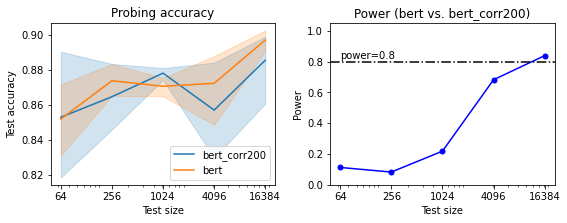

past_present,32,bert,bert_corr800,5,5,-0.0094,4363571,4363571,False
past_present,128,bert,bert_corr800,5,5,

/Users/zhuzi/miniforge3/envs/pytorch12/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/zhuzi/miniforge3/envs/pytorch12/lib/python3.9/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0.0156,1570885,1570885,False
past_present,512,bert,bert_corr800,5,5,-0.0041,22797434,22797434,False
past_present,2048,bert,bert_corr800,5,5,-0.0030,41846696,41846696,True
past_present,8192,bert,bert_corr800,5,5,0.0073,7294434,7294434,False


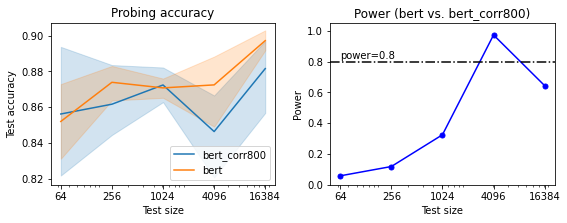

past_present,32,bert,bert_corr3200,5,5,-0.0063,9818035,9818035,False
past_present,128,bert,bert_corr3200,5,5,0.0187,1090892,1090892,False
past_present,512,bert,bert_corr3200,5,5,0.0303,418466,418466,False
past_present,2048,bert,bert_corr3200,5,5,-0.0307,406577,406577,False
past_present,8192,bert,bert_corr3200,5,5,0.0081,5855142,5855142,False


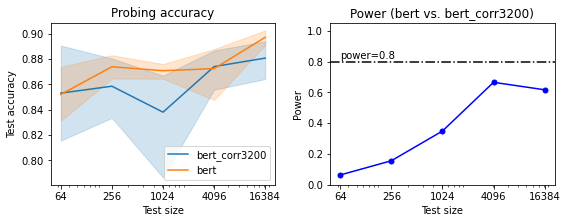

In [28]:
def compute_powers_between_model(df, metric="others", task="past_present",
                                 model1="bert", model2="infersent"):
    powers = []
    for vsize in all_val_sizes:
        df_short = df[(df.val_size_per_class==vsize) & \
                     (df.representation_gaussian_noise==0) & \
                     (df.probe_metric==metric) & \
                     (df.task==task) & (df.hid_sizes=="[]") & \
                     (df.seed < 64)]
        df_model1 = df_short[df_short.model==model1]
        df_model2 = df_short[df_short.model==model2]
        if len(df_model1) == 0:
            continue
        
        print("{},{},{},{},{},{}".format(task, vsize, model1, model2, len(df_model1), len(df_model2)), end=",")

        power = power_from_multiple_rows(df_model1, df_model2, 
            pred_col_name="test_predictions", label_col_name="test_labels")
        powers.append(power)
        
        # Update the training data requirement from effect sizes
        effect_size = (df_model1.test_acc.values - df_model2.test_acc.values).mean() / 2
        abs_effect_size = np.absolute(effect_size)
        n1_req_model1 = n1_requirement(abs_effect_size, model1)
        n1_req_model2 = n1_requirement(abs_effect_size, model2)
        print ("{:.4f},{},{},{}".format(effect_size*2, n1_req_model1, n1_req_model2, power>0.8))
    
    if task == "sentence_length":
        N_CLASS = 6
        xticks = all_val_sizes[:-1]
    else:
        N_CLASS = 2
        xticks = all_val_sizes
    xticks_texts = ["{0:g}".format(vs * N_CLASS) for vs in xticks]
    
    fig, axes = plt.subplots(1,2, figsize=(8,3.2))
    
    # Plot val_losses
    ax = axes[0]
    df_plot = df[(df.representation_gaussian_noise==0) & \
                (df.probe_metric==metric) & \
                (df.task==task) & \
                (df.model.isin([model1, model2]))]
    sns.lineplot(data=df_plot, x="val_size_per_class", y="test_acc",
                 hue="model", ax=ax)
    ax.set_ylabel("Test accuracy")
    ax.legend(loc="lower right")
    ax.set_xscale("log")
    ax.set_xticks(xticks)
    ax.set_xticklabels(xticks_texts)
    ax.set(xlabel="Test size")
    #if task == "past_present":
    #    ax.set_ylim([0.7,1])
    #elif task == "bigram_shift":
    #    ax.set_ylim([0.4, 0.9])
    ax.set_title("Probing accuracy")
    
    # Power analysis
    ax = axes[1]
    ax.plot(xticks, powers, color="blue", marker="o", markersize=5)
    ax.axhline(0.8, color="black", linestyle="dashdot")
    ax.text(32, 0.82, "power=0.8")
    ax.set_xscale("log")
    ax.set_xticks(xticks)
    ax.set_xticklabels(xticks_texts)
    ax.set_xlabel("Test size")
    ax.set_ylabel("Power")
    ax.set_ylim([0,1.05])
    ax.set_title(f"Power ({model1} vs. {model2})")

    # Export figure
    plt.tight_layout()
    plt.savefig(f"compare_models_plot/{task}_{model1}_{model2}.svg")
    plt.show()

for TASK in ["coordination_inversion", "sentence_length", "bigram_shift", "past_present"]:
    
    model_choices = ["bert", "sbert", "infersent", "glove"]
    for i in range(len(model_choices)):
        for j in range(i+1, len(model_choices)):
            compute_powers_between_model(df_all, task=TASK, model1=model_choices[i], model2=model_choices[j])

    compute_powers_between_model(df_all, task=TASK, model1="bert", model2="bert_corr200")
    compute_powers_between_model(df_all, task=TASK, model1="bert", model2="bert_corr800")
    compute_powers_between_model(df_all, task=TASK, model1="bert", model2="bert_corr3200")

## Compare between configs w/ and w/o hid sizes

sentence_length,32,bert_LogReg,bert_MLP20,5,5,-0.0490,40001,40001,False
sentence_length,128,bert_LogReg,bert_MLP20,5,5,-0.0301,105979,105979,False
sentence_length,512,bert_LogReg,bert_MLP20,5,5,-0.0289,114746,114746,True
sentence_length,2048,bert_LogReg,bert_MLP20,5,5,-0.0254,148437,148437,True


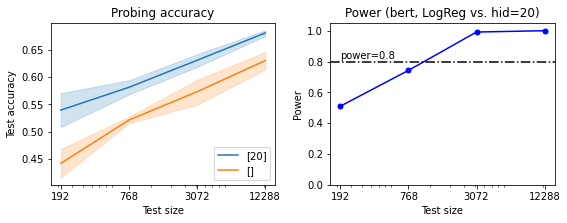

coordination_inversion,32,bert_LogReg,bert_MLP20,5,5,-0.0078,1570885,1570885,False
coordination_inversion,128,bert_LogReg,bert_MLP20,5,5,0.0098,1005366,1005366,False
coordination_inversion,512,bert_LogReg,bert_MLP20,5,5,0.0011,83088172,83088172,False
coordination_inversion,2048,bert_LogReg,bert_MLP20,5,5,-0.0044,4910066,4910066,False
coordination_inversion,8192,bert_LogReg,bert_MLP20,5,5,-0.0156,391497,391497,False


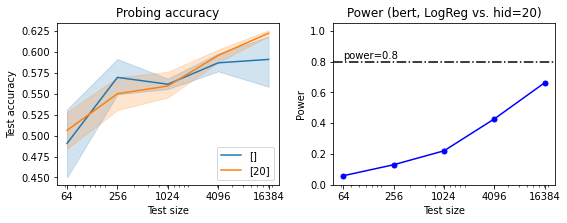

bigram_shift,32,bert_LogReg,bert_MLP20,5,5,0.0109,801472,801472,False
bigram_shift,128,bert_LogReg,bert_MLP20,5,5,-0.0090,1187815,1187815,False
bigram_shift,512,bert_LogReg,bert_MLP20,5,5,-0.0035,7757460,7757460,False
bigram_shift,2048,bert_LogReg,bert_MLP20,5,5,-0.0057,2912787,2912787,False
bigram_shift,8192,bert_LogReg,bert_MLP20,5,5,-0.0063,2444949,2444949,False


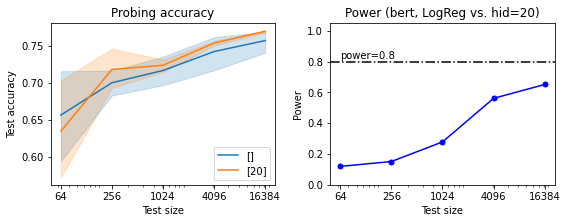

past_present,32,bert_LogReg,bert_MLP20,5,5,

/Users/zhuzi/miniforge3/envs/pytorch12/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/zhuzi/miniforge3/envs/pytorch12/lib/python3.9/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


-0.0031,9818035,9818035,False
past_present,128,bert_LogReg,bert_MLP20,5,5,0.0082,1424839,1424839,False
past_present,512,bert_LogReg,bert_MLP20,5,5,-0.0030,10461674,10461674,False
past_present,2048,bert_LogReg,bert_MLP20,5,5,-0.0226,188001,188001,False
past_present,8192,bert_LogReg,bert_MLP20,5,5,-0.0084,1369271,1369271,True


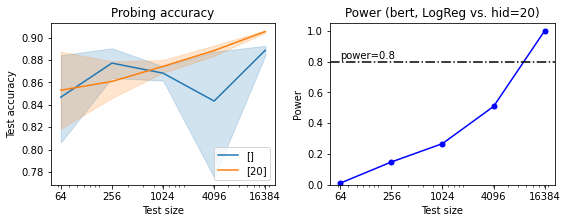

In [27]:
def compute_powers_between_hidsizes(df, metric="others", task="past_present",
                                 model="bert"):
    powers = []
    for vsize in all_val_sizes:
        df_short = df[(df.val_size_per_class==vsize) & \
                     (df.representation_gaussian_noise==0) & \
                     (df.probe_metric==metric) & \
                     (df.task==task) & \
                     (df.model==model) & \
                     (df.seed < 64)]
        df_config1 = df_short[df_short.hid_sizes=="[]"]
        df_config2 = df_short[df_short.hid_sizes=="[20]"]
        if len(df_config1) == 0:
            continue
        
        print("{},{},bert_LogReg,bert_MLP20,{},{}".format(task, vsize, len(df_config1), len(df_config2)), end=",")

        power = power_from_multiple_rows(df_config1, df_config2, 
            pred_col_name="test_predictions", label_col_name="test_labels")
        powers.append(power)
        
        # Update the training data requirement from effect sizes
        effect_size = (df_config1.test_acc.values - df_config2.test_acc.values).mean() /2
        abs_effect_size = np.absolute(effect_size)
        n1_req_config1 = n1_requirement(abs_effect_size, model)
        n1_req_config2 = n1_requirement(abs_effect_size, model)
        print ("{:.4f},{},{},{}".format(effect_size, n1_req_config1, n1_req_config2, power>0.8))
        
    if task == "sentence_length":
        N_CLASS = 6
        xticks = np.array(all_val_sizes[:-1])
    else:
        N_CLASS = 2
        xticks = np.array(all_val_sizes)
    xticks_texts = ["{0:d}".format(vs * N_CLASS) for vs in xticks]
    
    fig, axes = plt.subplots(1,2, figsize=(8,3.2))
    
    # Plot val_losses
    ax = axes[0]
    df_plot = df[(df.representation_gaussian_noise==0) & \
                (df.probe_metric==metric) & \
                (df.task==task) & \
                (df.model==model) & (df.seed < 64)]
    sns.lineplot(data=df_plot, x="val_size_per_class", y="test_acc",
                 hue="hid_sizes", ax=ax)
    ax.set_ylabel("Test accuracy")
    ax.legend(loc="lower right")
    ax.set_xscale("log")
    ax.set_xticks(xticks)
    ax.set_xticklabels(xticks_texts)
    ax.set(xlabel="Test size")
    #if task == "past_present":
    #    ax.set_ylim([0.7,1])
    #elif task == "bigram_shift":
    #    ax.set_ylim([0.4, 0.9])
    ax.set_title("Probing accuracy")
    
    # Power analysis
    ax = axes[1]
    ax.plot(xticks, powers, color="blue", marker="o", markersize=5)
    ax.axhline(0.8, color="black", linestyle="dashdot")
    ax.text(32, 0.82, "power=0.8")
    ax.set_xscale("log")
    ax.set_xticks(xticks)
    ax.set_xticklabels(xticks_texts)
    ax.set_xlabel("Test size")
    ax.set_ylabel("Power")
    ax.set_ylim([0,1.05])
    ax.set_title(f"Power ({model}, LogReg vs. hid=20)")

    # Export figure
    plt.tight_layout()
    plt.savefig(f"compare_models_plot/{task}_nohid_vs_hid20_{model}.svg")
    plt.show()
    
compute_powers_between_hidsizes(df_all, task="sentence_length", model="bert")
compute_powers_between_hidsizes(df_all, task="coordination_inversion", model="bert")
compute_powers_between_hidsizes(df_all, task="bigram_shift", model="bert")
compute_powers_between_hidsizes(df_all, task="past_present", model="bert")